<a href="https://colab.research.google.com/github/Eadgnus/Text-embedding/blob/master/%ED%95%9C%EA%B5%AD%EC%96%B4_%EC%9B%8C%EB%93%9C_%EC%9E%84%EB%B2%A0%EB%94%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups

import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
# 네거티브 샘플링을 위해 keras에서 제공하는 전처리 도구
from tensorflow.keras.preprocessing.sequence import skipgrams

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model
# 모델을 통해서 돌렸던 단어들을 텍스트로 만들고 활용가능하게 해줌
import gensim

In [ ]:
df = open('/content/drive/MyDrive/Colab Notebooks/수업/자연어처리/한국어 워드 임베딩 과제/modi_output.txt', 'r')

In [ ]:
df = pd.DataFrame({'document': df})

In [ ]:
df

,document
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다. 따라서 ...
1,진로체험의 운영 역량을 강화하기 위하여 단위학교의 담당교사 외 에도 진로체험을 인솔...
2,"매우 최근 의견에서, Mary Footer는 이 논쟁을 한발 더 진전시켰다. 그녀는..."
3,에너지원별 소비 비중의 변화에서 눈에 띄는 것은 전력비중이 1981년에 비해 2배 ...
4,"강원의 주류 기술지식 영역과 전략산업을 살펴보면 웰니스식품, 스포츠지식서비스, 의료..."
...,...
159997,유기성 폐기물 에너지화 시설 확대의 속성별 MWTP를 추정한 결과는 <표 5>에 제...
159998,일반적으로 정비하천은 자연하천에 비해 댐이나 보 등의 영향으로 하천유량이 많고 유속...
159999,NCATS는 CTSA 사업 이외에도 임상으로의 중개를 위해 다양한 사업들을 진행하는...
160000,해외 TA 방식과 또 다른 차이점으로는 국내의 경우에는 평가기술에 대한 과학적 지식...


In [ ]:
# 결측치 확인
df.replace('', float('NaN'), inplace=True)

# true false로 결측치 확인하기
print(df.isnull().values.any())

False


In [ ]:
# 중복된 데이터 열기준 제거
processed_news_df = df.drop_duplicates(['document']).reset_index(drop=True)
processed_news_df

,document
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다. 따라서 ...
1,진로체험의 운영 역량을 강화하기 위하여 단위학교의 담당교사 외 에도 진로체험을 인솔...
2,"매우 최근 의견에서, Mary Footer는 이 논쟁을 한발 더 진전시켰다. 그녀는..."
3,에너지원별 소비 비중의 변화에서 눈에 띄는 것은 전력비중이 1981년에 비해 2배 ...
4,"강원의 주류 기술지식 영역과 전략산업을 살펴보면 웰니스식품, 스포츠지식서비스, 의료..."
...,...
159997,유기성 폐기물 에너지화 시설 확대의 속성별 MWTP를 추정한 결과는 <표 5>에 제...
159998,일반적으로 정비하천은 자연하천에 비해 댐이나 보 등의 영향으로 하천유량이 많고 유속...
159999,NCATS는 CTSA 사업 이외에도 임상으로의 중개를 위해 다양한 사업들을 진행하는...
160000,해외 TA 방식과 또 다른 차이점으로는 국내의 경우에는 평가기술에 대한 과학적 지식...


In [ ]:
len(processed_news_df.iloc[0][0])

577

In [ ]:
# 특수문자 제거
processed_news_df['document'].str[0:]
processed_news_df['document'] = processed_news_df['document'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
processed_news_df['document']

0         자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 높다  따라서 ...
1         진로체험의 운영 역량을 강화하기 위하여 단위학교의 담당교사 외 에도 진로체험을 인솔...
2         매우 최근 의견에서  Mary Footer는 이 논쟁을 한발 더 진전시켰다  그녀는...
3         에너지원별 소비 비중의 변화에서 눈에 띄는 것은 전력비중이 1981년에 비해 2배 ...
4         강원의 주류 기술지식 영역과 전략산업을 살펴보면 웰니스식품  스포츠지식서비스  의료...
                                ...                        
159997    유기성 폐기물 에너지화 시설 확대의 속성별 MWTP를 추정한 결과는  표 5 에 제...
159998    일반적으로 정비하천은 자연하천에 비해 댐이나 보 등의 영향으로 하천유량이 많고 유속...
159999    NCATS는 CTSA 사업 이외에도 임상으로의 중개를 위해 다양한 사업들을 진행하는...
160000    해외 TA 방식과 또 다른 차이점으로는 국내의 경우에는 평가기술에 대한 과학적 지식...
160001    Cincera et al  2013 의 연구도 동일하다  EU Industrial ...
Name: document, Length: 160002, dtype: object

In [ ]:
# 데이터셋에 단어 길이가 2이하인것 제거
processed_news_df['document'] = processed_news_df['document'].apply(lambda x: ' '.join([token for token in x.split() if len(token) > 2]))
processed_news_df

,document
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 따라서 생각을 ...
1,진로체험의 역량을 강화하기 위하여 단위학교의 담당교사 진로체험을 인솔하거나 안전요원...
2,의견에서 Mary Footer는 논쟁을 진전시켰다 그녀는 비구속적 soft law ...
3,에너지원별 비중의 변화에서 전력비중이 1981년에 증가하였다는 것이다 연평균 지속적...
4,강원의 기술지식 영역과 전략산업을 살펴보면 웰니스식품 스포츠지식서비스 의료기기 바이...
...,...
159997,유기성 폐기물 에너지화 확대의 속성별 MWTP를 추정한 결과는 제시되어 MWTP는 ...
159998,일반적으로 정비하천은 자연하천에 댐이나 영향으로 하천유량이 유속이 느려서 지표수 지...
159999,NCATS는 CTSA 이외에도 임상으로의 중개를 다양한 사업들을 진행하는데 대다수는...
160000,방식과 차이점으로는 국내의 경우에는 평가기술에 과학적 경제성 사회적 효과가 하나의 ...


In [ ]:
# 전체 길이가 200 이하이거나 전체 단어 개수가 5개 이하인 데이터를 필터링
processed_news_df = processed_news_df[processed_news_df.document.apply(lambda x: len(str(x)) > 200 and len(str(x).split()) > 5)].reset_index(drop=True)
processed_news_df

,document
0,자신의 생각을 불명확하게 표현하는 사람들은 생각도 불명확할 가능성이 따라서 생각을 ...
1,진로체험의 역량을 강화하기 위하여 단위학교의 담당교사 진로체험을 인솔하거나 안전요원...
2,의견에서 Mary Footer는 논쟁을 진전시켰다 그녀는 비구속적 soft law ...
3,에너지원별 비중의 변화에서 전력비중이 1981년에 증가하였다는 것이다 연평균 지속적...
4,강원의 기술지식 영역과 전략산업을 살펴보면 웰니스식품 스포츠지식서비스 의료기기 바이...
...,...
159930,유기성 폐기물 에너지화 확대의 속성별 MWTP를 추정한 결과는 제시되어 MWTP는 ...
159931,일반적으로 정비하천은 자연하천에 댐이나 영향으로 하천유량이 유속이 느려서 지표수 지...
159932,NCATS는 CTSA 이외에도 임상으로의 중개를 다양한 사업들을 진행하는데 대다수는...
159933,방식과 차이점으로는 국내의 경우에는 평가기술에 과학적 경제성 사회적 효과가 하나의 ...


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
bool_dragon_fish = '아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 '
bool_dragon_fish = bool_dragon_fish.split(' ')
bool_dragon_fish[2]

'아이구'

In [ ]:
len(bool_dragon_fish)

889

In [ ]:
# 데이터셋에 불용어를 제외하여 띄어쓰기 단위로 문장을 분리
# [a, b, c, d, e, f, ...]

tokenized_doc = processed_news_df['document'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [s_word for s_word in x if s_word not in bool_dragon_fish])
tokenized_doc

0         [자신의, 생각을, 불명확하게, 표현하는, 사람들은, 생각도, 불명확할, 가능성이,...
1         [진로체험의, 역량을, 강화하기, 단위학교의, 담당교사, 진로체험을, 인솔하거나, ...
2         [의견에서, Mary, Footer는, 논쟁을, 진전시켰다, 그녀는, 비구속적, s...
3         [에너지원별, 비중의, 변화에서, 전력비중이, 1981년에, 증가하였다는, 것이다,...
4         [강원의, 기술지식, 영역과, 전략산업을, 살펴보면, 웰니스식품, 스포츠지식서비스,...
                                ...                        
159930    [유기성, 폐기물, 에너지화, 확대의, 속성별, MWTP를, 추정한, 결과는, 제시...
159931    [정비하천은, 자연하천에, 댐이나, 영향으로, 하천유량이, 유속이, 느려서, 지표수...
159932    [NCATS는, CTSA, 임상으로의, 중개를, 다양한, 사업들을, 진행하는데, 대...
159933    [방식과, 차이점으로는, 국내의, 경우에는, 평가기술에, 과학적, 경제성, 사회적,...
159934    [Cincera, 2013, 연구도, 동일하다, Industrial, Investm...
Name: document, Length: 159935, dtype: object

In [ ]:
type(tokenized_doc)

pandas.core.series.Series

In [ ]:
tokenized_doc = tokenized_doc.to_list()
print(len(tokenized_doc))

159935


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

In [ ]:
word2idx = tokenizer.word_index
idx2word = {value: key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
encoded[0]

[45,
 1505,
 69472,
 3656,
 1137,
 24225,
 75913,
 27,
 1505,
 16763,
 10471,
 724,
 55709,
 52311,
 162224,
 653262,
 13591,
 162225,
 409788,
 3253,
 2869,
 4472,
 82,
 122599,
 83753,
 7096,
 3934,
 173,
 11242,
 3517,
 805,
 7008,
 4556,
 16764,
 959,
 30100,
 30100,
 25259,
 6422,
 653263,
 24225,
 16763,
 16763,
 210242,
 64,
 308077,
 88279,
 48044,
 10784,
 409789,
 5921,
 12162,
 41240,
 653264,
 93426,
 225,
 249142,
 734,
 653265,
 295,
 2308,
 103,
 10361,
 743,
 19952,
 182770,
 249143,
 81,
 653266,
 308078,
 18433,
 614,
 3136,
 2995,
 81,
 5610,
 2869,
 4472,
 925,
 54001,
 11242,
 3517,
 8963,
 863,
 591,
 724,
 122600,
 173,
 724,
 64090,
 14,
 956,
 22490,
 653267,
 88279,
 48044,
 15422,
 1]

In [ ]:
vocab_size = len(word2idx) + 1
print(f'단어 사전의 크기: {vocab_size}')

단어 사전의 크기: 1464471


In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size = 10) for sample in encoded[:5]]
print(f'전체 샘플수: {len(skip_grams)}')

전체 샘플수: 5


In [ ]:
# skip_grams[0]에 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
print(f'3 pairs: {pairs[:3]}')
print(f'3 labels: {labels[:3]}')

3 pairs: [[10784, 625563], [225, 848190], [863, 5610]]
3 labels: [0, 0, 1]


In [ ]:
# 첫번째 뉴스그룹 샘플에 대해 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

3700
3700


In [ ]:
for i in range(5):
    print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]
    ))

(버리고 (10784), 땅콩을 (625563)) -> 0
(도움이 (225), 점거는 (848190)) -> 0
(이해하고 (863), 주제가 (5610)) -> 1
(설득기법을 (653265), 사용하는 (295)) -> 1
(정리하는 (10471), 아무리 (2869)) -> 1


In [ ]:
vocab_size = len(word2idx) + 1
print()

In [ ]:
training_dataset = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:5000]]

In [ ]:
embedding_dim = 100
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1,), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)
c_inputs = Input(shape=(1,), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [ ]:
dot_product = Dot(axes = 2)([word_embedding, context_embedding])
dot_product = Reshape((1, ), input_shape = (1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)
model = Model(inputs = [w_inputs, c_inputs], outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       146447100   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       146447100   ['input_2[0][0]']                
                                                                                              

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')

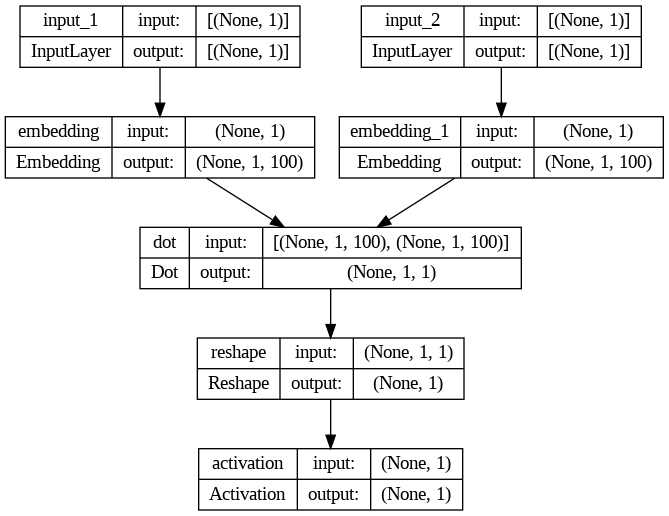

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
for epoch in range(50):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')

        labels = np.array(elem[1], dtype='int32')

        X = [first_elem, second_elem]
        Y = labels

        loss += model.train_on_batch(X, Y)
    print('Epoch:', epoch+1, 'Loss: ', loss)

Epoch: 1 Loss:  3.4657026529312134
Epoch: 2 Loss:  3.4579579830169678
Epoch: 3 Loss:  3.4499348402023315
Epoch: 4 Loss:  3.4411226511001587
Epoch: 5 Loss:  3.4312150478363037
Epoch: 6 Loss:  3.4198936223983765
Epoch: 7 Loss:  3.4068445563316345
Epoch: 8 Loss:  3.391768515110016
Epoch: 9 Loss:  3.3743844628334045
Epoch: 10 Loss:  3.354430377483368
Epoch: 11 Loss:  3.3316662311553955
Epoch: 12 Loss:  3.305875599384308
Epoch: 13 Loss:  3.2768701314926147
Epoch: 14 Loss:  3.2444927096366882
Epoch: 15 Loss:  3.2086201310157776
Epoch: 16 Loss:  3.1691664457321167
Epoch: 17 Loss:  3.126083552837372
Epoch: 18 Loss:  3.0793644189834595
Epoch: 19 Loss:  3.0290409922599792
Epoch: 20 Loss:  2.975187301635742
Epoch: 21 Loss:  2.9179157614707947
Epoch: 22 Loss:  2.8573782444000244
Epoch: 23 Loss:  2.7937622666358948
Epoch: 24 Loss:  2.7272903323173523
Epoch: 25 Loss:  2.6582146286964417
Epoch: 26 Loss:  2.5868154168128967
Epoch: 27 Loss:  2.51339590549469
Epoch: 28 Loss:  2.4382775723934174
Epoch: 2

In [ ]:
f = open('vectors.txt', 'w')
f.write('{} {}\n'.format(vocab_size -1, embedding_dim))
vectors = model.get_weights()[0]
# print(vectors)
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
# vocab이 종료되고 이 메소드로 바뀜
w2v.index_to_key

['것이다',
 '것으로',
 '다양한',
 '있으며',
 '영향을',
 '필요가',
 '사회적',
 '필요하다',
 '새로운',
 '있도록',
 '위해서는',
 '있다는',
 '나타났다',
 '중요한',
 '때문이다',
 '필요한',
 '있었다',
 '대상으로',
 '중심으로',
 '있다고',
 '역할을',
 '하였다',
 '보인다',
 '관련된',
 '서비스',
 '있는데',
 '가능성이',
 '되었다',
 '가지고',
 '연구는',
 '경제적',
 '경우에는',
 '미치는',
 '문제가',
 '정부의',
 '결과를',
 '문제를',
 '과정에서',
 '기업의',
 '있지만',
 '북한의',
 '차이가',
 '정보를',
 '따르면',
 '자신의',
 '경우가',
 '있어서',
 '있으나',
 '에너지',
 '있음을',
 '기존의',
 '한다는',
 '정부는',
 '미국의',
 '가능한',
 '등으로',
 '대해서는',
 '측면에서',
 '한국의',
 '바탕으로',
 '효과를',
 '지속적으로',
 '우리나라',
 '내용을',
 '정책을',
 '청소년',
 '관련하여',
 '지역의',
 '변화를',
 '중국의',
 '국가의',
 '살펴보면',
 '2014년',
 '이상의',
 '프로그램',
 '방안을',
 'and',
 '서비스를',
 '우리나라의',
 '구체적인',
 '않는다',
 '어려운',
 '연구에서는',
 '지원을',
 '사업을',
 '관계를',
 '글로벌',
 '관점에서',
 '2013년',
 '제공하는',
 '규정하고',
 '개인의',
 '정치적',
 '자료를',
 '다음과',
 '하나의',
 '활동을',
 '연구의',
 '적극적으로',
 '과정을',
 '2013',
 '중심의',
 '중요하다',
 '목적으로',
 '특성을',
 '차원에서',
 '방식으로',
 '의미한다',
 '못하고',
 '디지털',
 '가운데',
 '정책의',
 '2015년',
 '2014',
 '정부가',
 '어렵다',
 '상황에서',
 '않았다',
 '차이를',
 '프로그

In [ ]:
w2v.most_similar(positive=['영향을'])

[('농경사회에서', 0.4883684515953064),
 ('악보없이', 0.48038122057914734),
 ('수출가치는', 0.4513293504714966),
 ('감수하여야한다', 0.44971704483032227),
 ('채택하여고', 0.44806545972824097),
 ('주의집중결여', 0.4403770864009857),
 ('신선같이', 0.4363260865211487),
 ('직면함', 0.4285012483596802),
 ('아동권리협약과', 0.4277592897415161),
 ('피해국가에겐', 0.42680007219314575)]